### Outliers, Leverage, and Influence

Outliers are extreme values (either low or high) that may exist in certain datasets. These outliers can skew results and potentially lead to us misinterpreting our data and leading to incorrect conclusions. Also, it is important to note that linear regression models are extra sensitive to extreme values. This is partly due to fitting methods, such as OLS, which minimizes the sum of errors squared (including said extreme values).

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols

In [26]:
# Using the fish dataset again, but this time with different species (Roach)

fish = pd.read_csv('Data/fish.csv')
roach = fish[fish['species'] == 'Roach'].copy()

roach.head()

,species,mass_g,length_cm
35,Roach,40.0,12.9
36,Roach,69.0,16.5
37,Roach,78.0,17.5
38,Roach,87.0,18.2
39,Roach,120.0,18.6


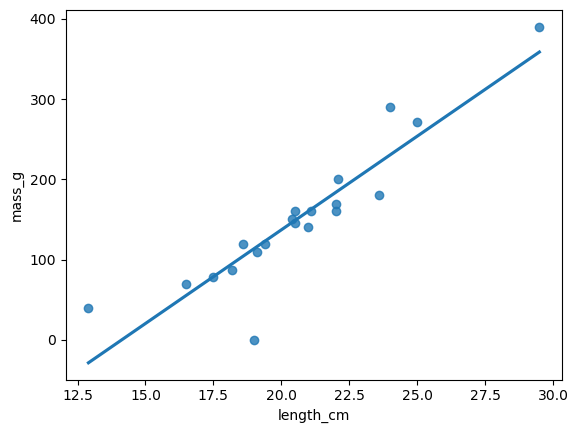

In [27]:
sns.regplot(
    x='length_cm',
    y='mass_g',
    data=roach,
    ci=None
)

plt.show()

*To highlight outliers on the plot, create a hue condition for seaborn and layer a scatterplot with that hue on top of the plot with the regression line*

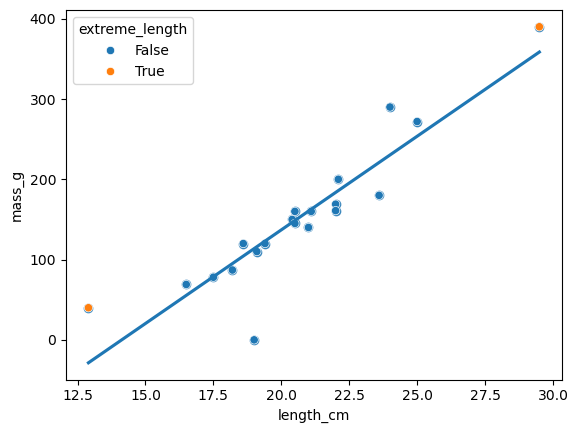

In [28]:
# Create the outlier column 
# Here, min. extreme values are < 15 and max. extreme values are > 26
roach['extreme_length'] = ((roach['length_cm'] < 15) | (roach['length_cm'] > 26))

fig = plt.figure()

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=roach,
    ci=None
)

sns.scatterplot(
    x='length_cm',
    y='mass_g',
    data=roach,
    hue='extreme_length'
)

plt.show()

From the data, it looks like there is one extremely short roach and another one that is extremely long. Also, note that not only extremely small/large values are outliers but also those datapoints that lie very far from the regression line. Notice the datapoint with a y-value at mass zero. Apart from the fact that it is far below the regression line, it is also biologically unlikely for an organism to have a mass of zero.

##### Leverage and Influence

**Leverage** is a measure of how extreme your independent variables are.

**Influence** measures how much the model will change if you leave the extreme observations out of the dataset. Think of it as a "leave one out" metric, or rather certain data's opportunity to cause change.

Also, note that the influence of each observation is based on the size of the residuals and the leverage. To print these metrics, chain the methods `.get_influence()` and `.summary_frame()` to the model object. 

Note that leverage values are stored in the `hat_diag` column. `hat_diag` represents the **hat matrix** and is a projection matrix that maps the response variable vector to the vector of fitted values in linear regression. Just remember that leverage values are stored in a hat matrix.

In [32]:
roach_length_vs_mass = ols('mass_g ~ length_cm', data=roach).fit()

roach_summary = roach_length_vs_mass.get_influence().summary_frame()

# A new column on the roach dataset called leverage
roach['leverage'] = roach_summary.hat_diag

roach.head()

,species,mass_g,length_cm,extreme_length,leverage
35,Roach,40.0,12.9,True,0.313729
36,Roach,69.0,16.5,False,0.125538
37,Roach,78.0,17.5,False,0.093487
38,Roach,87.0,18.2,False,0.076283
39,Roach,120.0,18.6,False,0.068387


In [31]:
# Sort by high leverage
roach.sort_values(by='leverage', ascending=False).head()

,species,mass_g,length_cm,extreme_length,leverage
54,Roach,390.0,29.5,True,0.394740
35,Roach,40.0,12.9,True,0.313729
53,Roach,272.0,25.0,False,0.133386
36,Roach,69.0,16.5,False,0.125538
52,Roach,290.0,24.0,False,0.099488


Notice that the roach fish with extreme high and low values are the ones with the large leverage values.

##### Cook's Distance

Cook's Distance is another measure in regression analysis that is used to identify influential datapoints in the model. A datapoint with a low Cook's distance value (close to 0) indicates that it isn't affecting the fit much, thus it's removal will not significantly affect the model. A high Cook's distance value is considered influential and removal of such datapoints would affect the regression's results.

Cook's distance can be accessed from the same dataframe acquired by chaining the two method calls above.

In [35]:
roach['cooks_dist'] = roach_summary.cooks_d

# Sorting in descending order
roach.sort_values(by='cooks_dist', ascending=False).head()

,species,mass_g,length_cm,extreme_length,leverage,cooks_dist
35,Roach,40.0,12.9,True,0.313729,1.074015
54,Roach,390.0,29.5,True,0.394740,0.365782
40,Roach,0.0,19.0,False,0.061897,0.311852
52,Roach,290.0,24.0,False,0.099488,0.150064
51,Roach,180.0,23.6,False,0.088391,0.061209


Note the first three datapoints:
- Row 35 shows the shortest roach (highest cook's distance)
- Row 54 shows the longest roach; and
- Row 40 shows the roach with zero mass

Let's see influence in action. That is, how the fit changes after removing the most influential value.

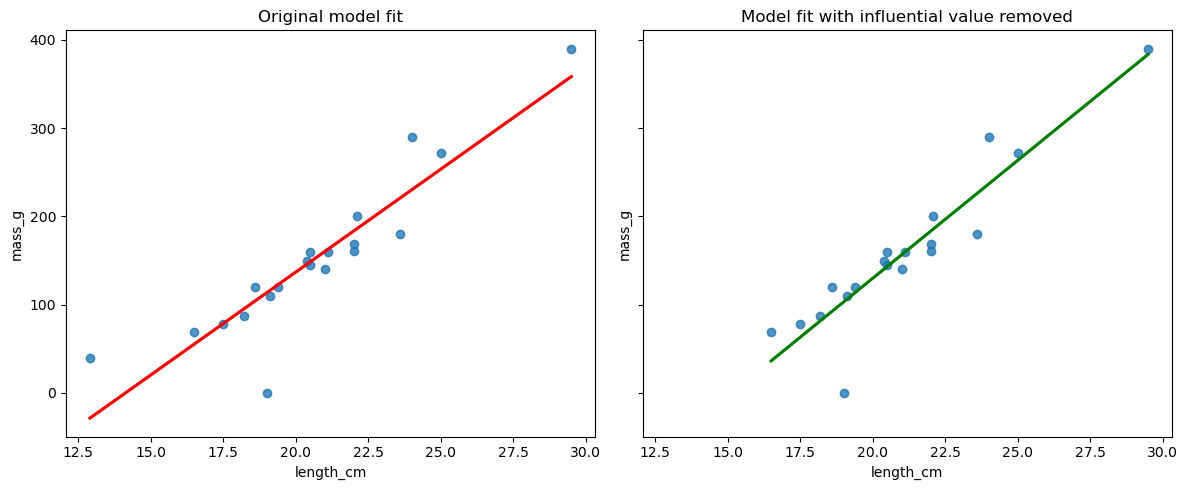

In [41]:
roach_no_short = roach[roach['length_cm'] != 12.9]

# Using two plots to visualize the difference in model fit

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=roach,
    ci=None,
    line_kws={'color':'r'},
    ax=ax[0]
)

ax[0].set_title('Original model fit')

sns.regplot(
    x='length_cm',
    y='mass_g',
    data=roach_no_short,
    ci=None,
    line_kws={'color':'g'},
    ax=ax[1]
)

ax[1].set_title('Model fit with influential value removed')

plt.tight_layout()
plt.show()

Notice the change in the line's slope after removing an influential value.